In [4]:
import mlflow
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
# =====================================
# MLflow setup
# =====================================
mlflow.set_tracking_uri(
    "https://dagshub.com/Y-R-A-V-R-5/DownScaleXR.mlflow"
)

EXPERIMENT_NAME = "DownScaleXR"

experiment = mlflow.get_experiment_by_name(EXPERIMENT_NAME)
assert experiment is not None, "Experiment not found"

runs = mlflow.search_runs(
    experiment_ids=[experiment.experiment_id]
)

In [6]:
# =====================================
# Select important columns only
# =====================================
KEY_COLUMNS = [
    # Identity
    "run_id",
    "tags.model_name",
    "tags.downsampling",

    # Validation performance (primary)
    "metrics.val_auc",
    "metrics.val_f1_score",
    "metrics.val_precision",
    "metrics.val_recall",
    "metrics.val_accuracy",

    # Training sanity (overfitting signals)
    "metrics.train_accuracy",
    "metrics.train_loss",

    # Efficiency (CPU-centric)
    "metrics.inference_time_ms",
    "metrics.throughput_fps",
    "metrics.model_parameters",
    "metrics.model_size_mb",
]

In [7]:
df = runs[KEY_COLUMNS].copy()

# Clean column names
df.columns = (
    df.columns
    .str.replace("metrics.", "", regex=False)
    .str.replace("tags.", "", regex=False)
)

# Sort for readability
df = df.sort_values("val_auc", ascending=False).reset_index(drop=True)

display(df)

,run_id,model_name,downsampling,val_auc,val_f1_score,val_precision,val_recall,val_accuracy,train_accuracy,train_loss,inference_time_ms,throughput_fps,model_parameters,model_size_mb
0,32980289b4464f778ec495ca314325d3,lenet_strided,strided,0.895349,0.820404,0.696751,0.997416,0.726537,0.988632,0.035910,50.768445,608.645784,11396621.0,43.474659
1,8c745208b4284f44952affd0d22cfc78,lenet_avgpool,avgpool,0.890483,0.814346,0.688057,0.997416,0.715210,0.979961,0.048520,78.202355,395.128766,11396621.0,43.474659
2,b44260a78bbc46cba9e0f18db5b1fb9d,lenet_maxpool,maxpool,0.854324,0.836601,0.723164,0.992248,0.757282,0.996146,0.011788,168.695285,183.170502,11396621.0,43.474659


,downsampling,val_auc,val_f1_score,val_accuracy
model_name,,,,
lenet_strided,strided,0.895349,0.820404,0.726537
lenet_avgpool,avgpool,0.890483,0.814346,0.715210
lenet_maxpool,maxpool,0.854324,0.836601,0.757282


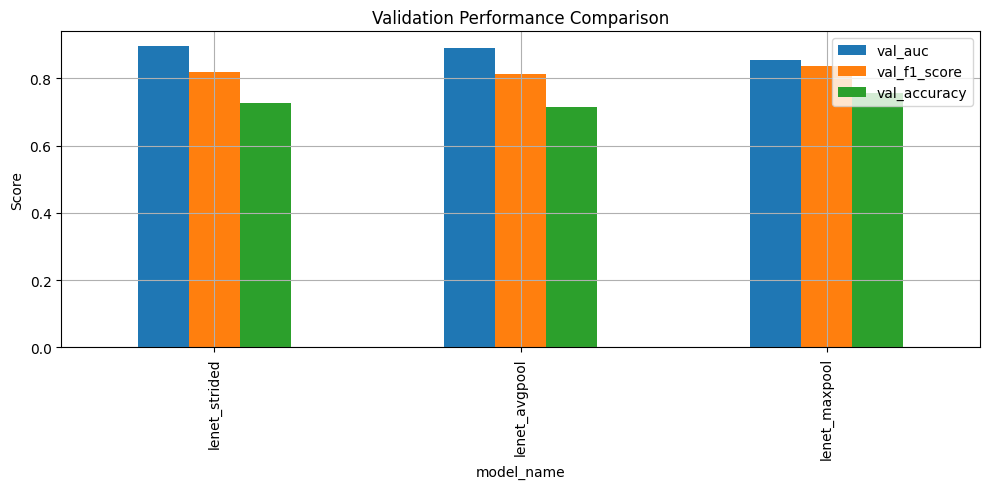

In [8]:
# =====================================
# 1. Performance comparison
# =====================================
perf_cols = [
    "model_name",
    "downsampling",
    "val_auc",
    "val_f1_score",
    "val_accuracy"
]

perf_df = df[perf_cols].set_index("model_name")
display(perf_df)

perf_df.plot(
    kind="bar",
    figsize=(10, 5),
    title="Validation Performance Comparison"
)
plt.ylabel("Score")
plt.grid(True)
plt.tight_layout()
plt.show()

,downsampling,inference_time_ms,throughput_fps,model_parameters,model_size_mb
model_name,,,,,
lenet_strided,strided,50.768445,608.645784,11396621.0,43.474659
lenet_avgpool,avgpool,78.202355,395.128766,11396621.0,43.474659
lenet_maxpool,maxpool,168.695285,183.170502,11396621.0,43.474659


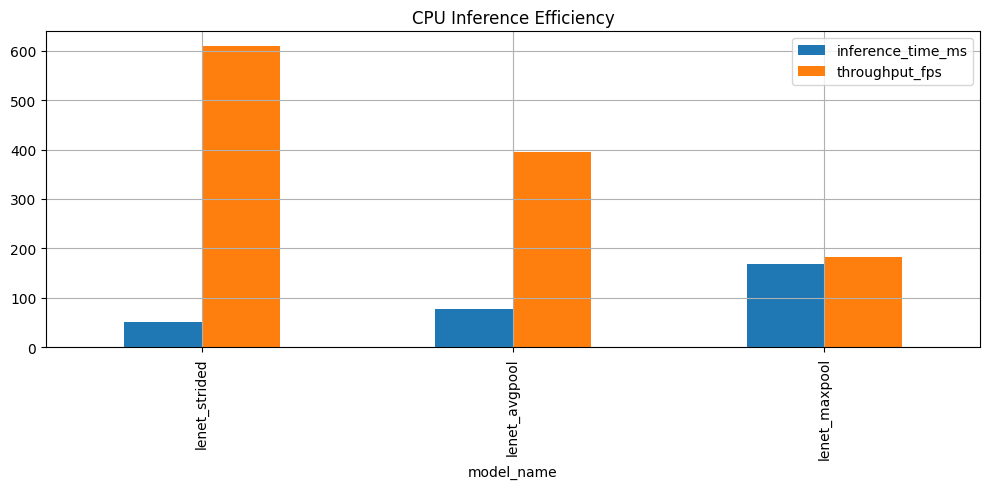

In [9]:

# =====================================
# 2. Efficiency comparison (CPU)
# =====================================
eff_cols = [
    "model_name",
    "downsampling",
    "inference_time_ms",
    "throughput_fps",
    "model_parameters",
    "model_size_mb"
]

eff_df = df[eff_cols].set_index("model_name")
display(eff_df)

eff_df[["inference_time_ms", "throughput_fps"]].plot(
    kind="bar",
    figsize=(10, 5),
    title="CPU Inference Efficiency"
)
plt.grid(True)
plt.tight_layout()
plt.show()

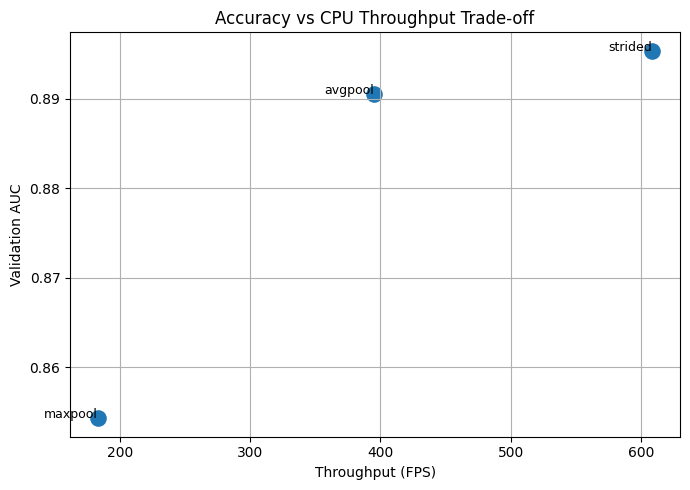

In [10]:

# =====================================
# 3. Accuracy vs Throughput trade-off
# =====================================
plt.figure(figsize=(7, 5))
plt.scatter(
    df["throughput_fps"],
    df["val_auc"],
    s=120
)

for _, row in df.iterrows():
    plt.text(
        row["throughput_fps"],
        row["val_auc"],
        row["downsampling"],
        fontsize=9,
        ha="right"
    )

plt.xlabel("Throughput (FPS)")
plt.ylabel("Validation AUC")
plt.title("Accuracy vs CPU Throughput Trade-off")
plt.grid(True)
plt.tight_layout()
plt.show()

,model_name,downsampling,train_accuracy,val_accuracy,generalization_gap
0,lenet_strided,strided,0.988632,0.726537,0.262095
1,lenet_avgpool,avgpool,0.979961,0.715210,0.264751
2,lenet_maxpool,maxpool,0.996146,0.757282,0.238865


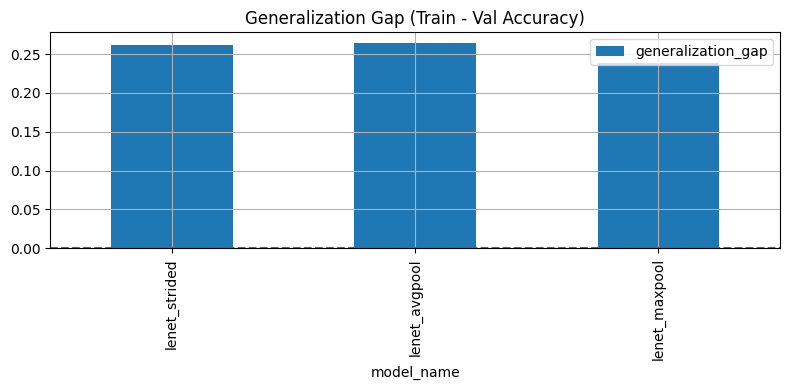

In [11]:

# =====================================
# 4. Overfitting signal check
# =====================================
overfit_df = df[
    [
        "model_name",
        "downsampling",
        "train_accuracy",
        "val_accuracy"
    ]
].copy()

overfit_df["generalization_gap"] = (
    overfit_df["train_accuracy"] - overfit_df["val_accuracy"]
)

display(overfit_df)

overfit_df.set_index("model_name")[
    ["generalization_gap"]
].plot(
    kind="bar",
    figsize=(8, 4),
    title="Generalization Gap (Train - Val Accuracy)"
)
plt.axhline(0, linestyle="--")
plt.grid(True)
plt.tight_layout()
plt.show()

In [12]:

# =====================================
# 5. Final ranked summary table
# =====================================
summary_cols = [
    "model_name",
    "downsampling",
    "val_auc",
    "throughput_fps",
    "inference_time_ms",
    "model_parameters"
]

summary = df[summary_cols].sort_values(
    ["val_auc", "throughput_fps"],
    ascending=[False, False]
)

display(summary)
# Save summary to CSV

,model_name,downsampling,val_auc,throughput_fps,inference_time_ms,model_parameters
0,lenet_strided,strided,0.895349,608.645784,50.768445,11396621.0
1,lenet_avgpool,avgpool,0.890483,395.128766,78.202355,11396621.0
2,lenet_maxpool,maxpool,0.854324,183.170502,168.695285,11396621.0


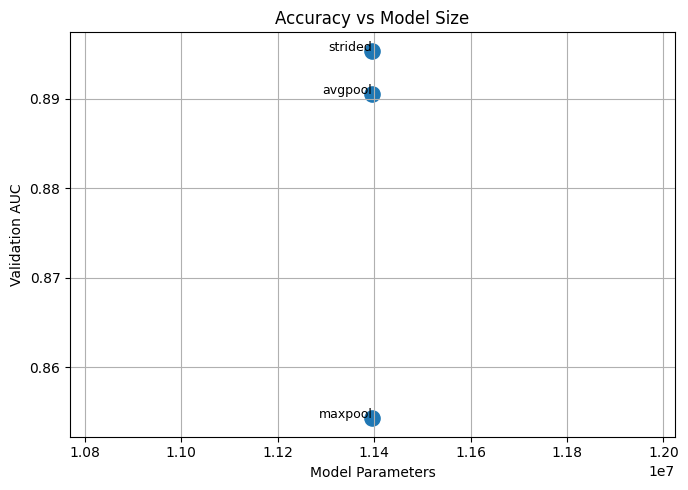

In [13]:
plt.figure(figsize=(7, 5))
plt.scatter(
    df["model_parameters"],
    df["val_auc"],
    s=120
)

for _, row in df.iterrows():
    plt.text(
        row["model_parameters"],
        row["val_auc"],
        row["downsampling"],
        fontsize=9,
        ha="right"
    )

plt.xlabel("Model Parameters")
plt.ylabel("Validation AUC")
plt.title("Accuracy vs Model Size")
plt.grid(True)
plt.tight_layout()
plt.show()

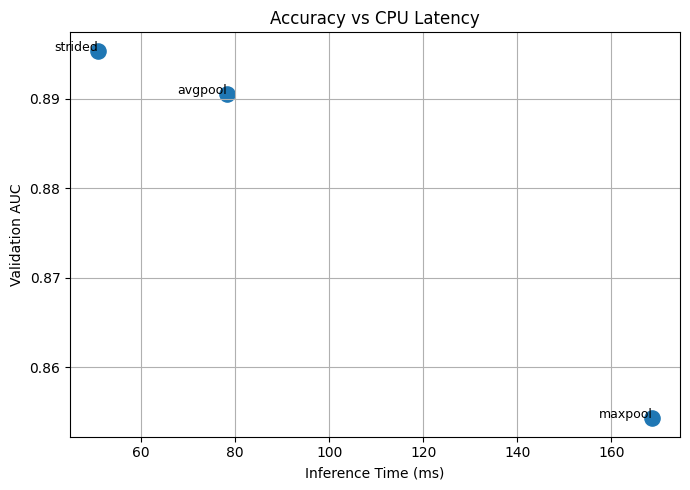

In [14]:
plt.figure(figsize=(7, 5))
plt.scatter(
    df["inference_time_ms"],
    df["val_auc"],
    s=120
)

for _, row in df.iterrows():
    plt.text(
        row["inference_time_ms"],
        row["val_auc"],
        row["downsampling"],
        fontsize=9,
        ha="right"
    )

plt.xlabel("Inference Time (ms)")
plt.ylabel("Validation AUC")
plt.title("Accuracy vs CPU Latency")
plt.grid(True)
plt.tight_layout()
plt.show()
# =====================================

In [15]:
rank_df = df.copy()

rank_df["auc_rank"] = rank_df["val_auc"].rank(ascending=False)
rank_df["fps_rank"] = rank_df["throughput_fps"].rank(ascending=False)
rank_df["size_rank"] = rank_df["model_parameters"].rank(ascending=True)

display(
    rank_df[
        ["model_name", "downsampling", "auc_rank", "fps_rank", "size_rank"]
    ]
)

,model_name,downsampling,auc_rank,fps_rank,size_rank
0,lenet_strided,strided,1.0,1.0,2.0
1,lenet_avgpool,avgpool,2.0,2.0,2.0
2,lenet_maxpool,maxpool,3.0,3.0,2.0


In [16]:
df["efficiency_score"] = (
    0.25 * (df["throughput_fps"] / df["throughput_fps"].max()) +
    0.25 * (1 - df["inference_time_ms"] / df["inference_time_ms"].max()) +
    0.20 * (1 - df["model_parameters"] / df["model_parameters"].max()) +
    0.15 * (1 - df["model_size_mb"] / df["model_size_mb"].max())
)

df["final_score"] = (
    0.6 * (df["val_auc"] / df["val_auc"].max()) +
    0.4 * df["efficiency_score"]
)

display(
    df[
        ["model_name", "downsampling", "val_auc", "final_score"]
    ].sort_values("final_score", ascending=False)
)

,model_name,downsampling,val_auc,final_score
0,lenet_strided,strided,0.895349,0.769905
1,lenet_avgpool,avgpool,0.890483,0.715301
2,lenet_maxpool,maxpool,0.854324,0.602603
